In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import sys
import matplotlib.pyplot as plt
import random

In [2]:
lim = 30
resolution = 100

Xn = np.expand_dims(np.linspace(-lim,lim,resolution),1)
Yn = np.expand_dims(np.linspace(-lim,lim,resolution)+np.linspace(-lim,lim,resolution)*np.sin(np.linspace(-lim,lim,resolution)),1)

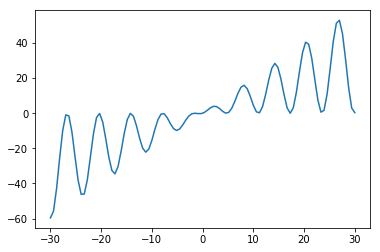

In [3]:
plt.plot(Xn,Yn)

In [4]:
def plot_GP(pred_mean,pred_covar,train_inputs,train_outputs,test_inputs):
    fig, ax = plt.subplots()
    plt.plot(train_inputs, train_outputs, '+k')
    pred_mean = pred_mean.data.numpy()
    pred_sd = np.sqrt(pred_covar.data.numpy().diagonal())
    plt.plot(test_inputs, pred_mean, color='b')
    plt.fill_between(np.squeeze(test_inputs), np.squeeze(pred_mean) + 2*pred_sd, 
                     np.squeeze(pred_mean) - 2*pred_sd, color='b', alpha=0.3)

In [17]:
class variational_GP(nn.Module):
    
    def __init__(self, Xn, Yn):   # the GP takes the training data as arguments, in the form of numpy arrays, with the correct dimensions
        
        super().__init__()
        # initialise hyperparameters
        self.Xm = nn.Parameter(torch.Tensor(Xn[random.sample(range(Xn.shape[0]),30)]).type(torch.FloatTensor))
        self.Xn = torch.tensor(Xn).type(torch.FloatTensor)
        self.Yn = torch.tensor(Yn).type(torch.FloatTensor)
        self.no_inputs = Xn.shape[1]
        self.logsigmaf2 = nn.Parameter(torch.Tensor([0])) # function variance
        self.logl2 = nn.Parameter(torch.zeros(self.no_inputs)) # horizontal length scales
        self.logsigman2 = nn.Parameter(torch.Tensor([0])) # noise variance
        
    def get_K(self,inputs1,inputs2):
        
        inputs1_col = torch.unsqueeze(inputs1.transpose(0,1), 2)
        inputs2_row = torch.unsqueeze(inputs2.transpose(0,1), 1)
        squared_distances = (inputs1_col - inputs2_row)**2        
        length_factors = (1/(2*torch.exp(self.logl2))).reshape(self.no_inputs,1,1)
        K = torch.exp(self.logsigmaf2) * torch.exp(-torch.sum(length_factors * squared_distances, 0))
        return(K)
    
    def Fv_inv(self): # All the necessary arguments are instance variables, so no need to pass them

        # Compute first term (log marginal likelihood)
        M = self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2) * torch.mm(self.get_K(self.Xm,self.Xn),self.get_K(self.Xm,self.Xn).transpose(0,1))
        #print(torch.eig(M))
        L = torch.potrf(M,upper=False)
        LslashKmnYn, _ = torch.trtrs(torch.mm(self.get_K(self.Xm,self.Xn),self.Yn),L,upper=False)
        log_marg = (- Xn.shape[0] * Xn.shape[1] / 2 * torch.log(torch.Tensor([2*np.pi])) # n*D/2 * log(2*pi)
                    - Xn.shape[0] / 2 * (torch.log(torch.det(self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2)*torch.mm(self.get_K(self.Xm,self.Xn),self.get_K(self.Xm,self.Xn).transpose(0,1)))) 
                                          - torch.log(torch.det(self.get_K(self.Xm,self.Xm))) + torch.log(Xn.shape[0]*torch.exp(self.logsigman2))) 
                    # -n/2 (log det(self.get_K(self.Xm,self.Xm) + 1/sigma^2*self.get_K(self.Xm,self.Xn)*self.get_K(self.Xm,self.Xn).transpose(0,1)) - log det (self.get_K(self.Xm,self.Xm)) + log(n*sigma^2))
                    - 1/torch.exp(self.logsigman2)*torch.mm(self.Yn.transpose(0,1),self.Yn) # - 1/sigma^2 * y^T y 
                    - 1/torch.exp(self.logsigman2)**2 * torch.mm(LslashKmnYn.transpose(0,1),LslashKmnYn)) # - 1/sigma^4 * b^T b
        # Compute second term (trace, regularizer)
        TrKnn = 0
        for elem in self.Xn:
            TrKnn += self.get_K(elem.unsqueeze(0),elem.unsqueeze(0))

        L = torch.potrf(self.get_K(self.Xm,self.Xm),upper=False)
        LslashKmn, _ = torch.trtrs(self.get_K(self.Xm,self.Xn),L,upper=False)
        TrKKK = torch.sum(LslashKmn * LslashKmn)       
        reg = - 1/torch.exp(self.logsigman2) * TrKnn - TrKKK
        return(log_marg + reg)
    
    def posterior_predictive(self,test_inputs):
        
        test_inputs = torch.Tensor(test_inputs)
        Sigma = self.get_K(self.Xm,self.Xm) + 1/torch.exp(self.logsigman2) * torch.mm(self.get_K(self.Xn,self.Xm).transpose(0,1),
                                                              self.get_K(self.Xn,self.Xm))

        #Mean
        L = torch.potrf(Sigma,upper=False)
        LslashKmnYn, _ = torch.trtrs(torch.mm(self.get_K(self.Xn,self.Xm).transpose(0,1),self.Yn),L,upper=False)
        aT, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmLslash = aT.transpose(0,1)
        myq = 1/torch.exp(self.logsigman2) * torch.mm(KxmLslash,LslashKmnYn)

        #Second term of the covariance

        L = torch.potrf(self.get_K(self.Xm,self.Xm),upper=False)
        aT, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmLTslash = aT.transpose(0,1)
        LslashKmx, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmKmminvKmx = torch.mm(KxmLTslash,LslashKmx)

        #Third term of the variance

        L = torch.potrf(Sigma,upper=False)
        aT, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmLTslash = aT.transpose(0,1)
        LslashKmx, _ = torch.trtrs(self.get_K(test_inputs,self.Xm).transpose(0,1),L,upper=False)
        KxmSigmainvKmx = torch.mm(KxmLTslash,LslashKmx)

        #Whole covariance
        kyq = self.get_K(test_inputs,test_inputs) - KxmKmminvKmx + KxmSigmainvKmx
        
        return(myq,kyq)
        
    
    def optimize_parameters(self,no_iters,method):
        
        # Set criterion and optimizer FOR NOW I'M GONNA USE ADAM ONLY
        '''if method == 'BFGS':
            optimizer = optim.LBFGS(self.parameters(), lr=1)  
        elif method == 'Adam':
            optimizer = optim.Adam(self.parameters(), lr=0.001)
        else: 
            sys.exit('method must be either \'BFGS\' or \'Adam\'') # An exception would be better
        
        for iteration in range(no_iters):
            optimizer.zero_grad()
            loss = self.Fv_inv() # Forward
            loss.backward() # Backward
            optimizer.step() # Optimize'''
            
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for iteration in range(no_iters):
            optimizer.zero_grad()
            loss = self.Fv_inv() # Forward. WHY DON'T I HAVE TO NEGATE THIS?
            loss.backward() # Backward
            optimizer.step() # Optimize
            
            if iteration%50 == 0:
                print(iteration,loss)


In [18]:
myGP = variational_GP(Xn, Yn)

After optimization, the variational lower bound has been maximized and the parameters have changed.

### Before:

In [19]:
myGP.Fv_inv()

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


tensor([[-76524.3438]], grad_fn=<AddBackward0>)

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


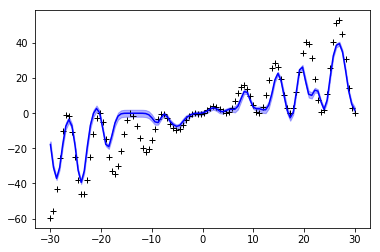

In [20]:
pred_mean, pred_covar = myGP.posterior_predictive(Xn)
plot_GP(pred_mean,pred_covar,Xn,Yn,Xn)

### During and after:

In [21]:
myGP.optimize_parameters(500,'Adam')

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


0 tensor([[-76524.3438]], grad_fn=<AddBackward0>)
50 tensor([[-82242.8203]], grad_fn=<AddBackward0>)
100 tensor([[-88415.7734]], grad_fn=<AddBackward0>)
150 tensor([[-95070.8359]], grad_fn=<AddBackward0>)
200 tensor([[-102226.6250]], grad_fn=<AddBackward0>)
250 tensor([[-109912.3281]], grad_fn=<AddBackward0>)
300 tensor([[-118170.9375]], grad_fn=<AddBackward0>)
350 tensor([[-127058.5938]], grad_fn=<AddBackward0>)
400 tensor([[-136642.3125]], grad_fn=<AddBackward0>)
450 tensor([[-146997.0156]], grad_fn=<AddBackward0>)


/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


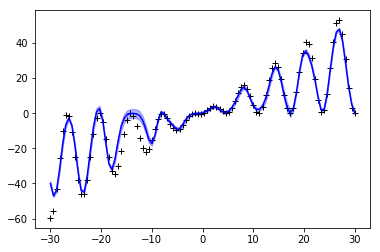

In [22]:
pred_mean, pred_covar = myGP.posterior_predictive(Xn)
plot_GP(pred_mean,pred_covar,Xn,Yn,Xn)

In [23]:
myGP.optimize_parameters(500,'Adam')

/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


0 tensor([[-158202.5938]], grad_fn=<AddBackward0>)
50 tensor([[-167716.2656]], grad_fn=<AddBackward0>)
100 tensor([[-177822.7031]], grad_fn=<AddBackward0>)
150 tensor([[-188615.4375]], grad_fn=<AddBackward0>)
200 tensor([[-200167.2031]], grad_fn=<AddBackward0>)
250 tensor([[-212554.6094]], grad_fn=<AddBackward0>)
300 tensor([[-225866.5938]], grad_fn=<AddBackward0>)
350 tensor([[-240206.8125]], grad_fn=<AddBackward0>)
400 tensor([[-255681.2031]], grad_fn=<AddBackward0>)
450 tensor([[-272419.7812]], grad_fn=<AddBackward0>)


/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.
/home/frozenmiwe/anaconda3/envs/music/lib/python3.6/site-packages/ipykernel_launcher.py:71: UserWarning: torch.potrf is deprecated in favour of torch.cholesky and will be removed in the next release. Please use torch.cholesky instead and note that the :attr:`upper` argument in torch.cholesky defaults to ``False``.


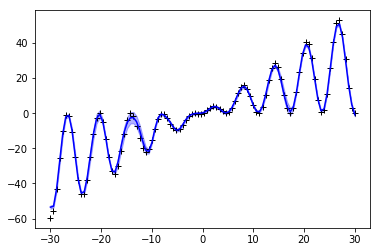

In [24]:
pred_mean, pred_covar = myGP.posterior_predictive(Xn)
plot_GP(pred_mean,pred_covar,Xn,Yn,Xn)